# a) Dataloader

In [19]:
import torch
from torch.utils.data import Dataset, DataLoader, random_split
import numpy as np

class MNISTDataset(Dataset):
    def __init__(self, images_file, labels_file=None, transform=None):
        self.images = np.load(images_file).reshape(-1, 28, 28) # Adjusted to ensure images are in correct shape
        self.labels = np.load(labels_file) if labels_file else None
        self.transform = transform

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        image = self.images[idx]
        if self.transform:
            image = self.transform(image)
        else:
            # Ensure the image is a float tensor with shape [1, 28, 28]
            image = torch.tensor(image, dtype=torch.float).unsqueeze(0)
        
        if self.labels is not None:
            label = self.labels[idx]
            label = torch.tensor(label, dtype=torch.long)
            return image, label
        return image


In [20]:
def create_data_loaders(batch_size, validation_split=0.2):
    
    dataset = MNISTDataset('/Users/ritikanigam/Downloads/x_train.npy', '/Users/ritikanigam/Downloads/y_train.npy')

    # Splitting dataset into training and validation
    val_size = int(len(dataset) * validation_split)
    train_size = len(dataset) - val_size
    train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

    # Test dataset (no labels here)
    test_dataset = MNISTDataset('/Users/ritikanigam/Downloads/x_test.npy')

    # Creating data loaders
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

    return train_loader, val_loader, test_loader, train_dataset


The above code snippet defines a custom dataset and data loaders for handling the MNIST dataset using PyTorch. The MNISTDataset class is designed to load and preprocess image and label data from specified numpy files, reshaping images into the correct format and converting them to tensors. The script includes functionality to optionally apply transformations to the images during loading. The create_data_loaders function sets up the data for training, validation, and testing by splitting the main dataset into training and validation subsets, and preparing a separate test dataset without labels. Data loaders are created for each subset to facilitate efficient batch processing and shuffling of data during model training, using the specified batch size and validation split ratio. This setup is essential for training and validating a neural network model on the MNIST dataset.

# b) Data Exploration

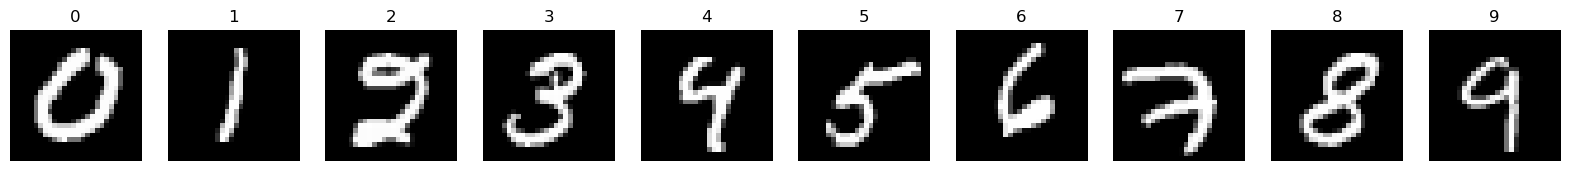

In [21]:
import matplotlib.pyplot as plt
import numpy as np

# Load the data
x_train = np.load('/Users/ritikanigam/Downloads/x_train.npy')
y_train = np.load('/Users/ritikanigam/Downloads/y_train.npy')

fig, axes = plt.subplots(1, 10, figsize=(20, 2))
for digit in range(10):
    for i, label in enumerate(y_train):
        if label == digit:
            # Reshape the image to 28x28 before displaying
            image = x_train[i].reshape(28, 28)
            ax = axes[digit]
            ax.imshow(image, cmap='gray')
            ax.axis('off')
            ax.set_title(str(digit))
            break
plt.show()



The above code snippet uses Matplotlib and NumPy to visualize the first occurrence of each digit (0 through 9) from the MNIST dataset. It begins by loading the training images (x_train) and their corresponding labels (y_train) from specified numpy files. The script then creates a figure with 10 subplots, one for each digit. It iterates through the labels to find the first instance of each digit, reshapes the corresponding image from a flat array into a 28x28 matrix, and displays it in the appropriate subplot. Each subplot is configured to display the image in grayscale, remove axis markings for clarity, and label the image with the corresponding digit. The visualization helps in verifying that the dataset contains correctly labeled images of each digit, facilitating a quick inspection of sample data.

In [22]:
# Count the number of samples per digit
samples_per_digit = np.bincount(y_train)

# Print the count for each digit
for digit, count in enumerate(samples_per_digit):
    print(f"Digit {digit}: {count} samples")

# Check if the distribution is balanced
is_balanced = np.all(samples_per_digit == samples_per_digit[0])
print(f"\nIs the data distribution balanced? {'Yes' if is_balanced else 'No'}")


Digit 0: 5923 samples
Digit 1: 6742 samples
Digit 2: 5958 samples
Digit 3: 6131 samples
Digit 4: 5842 samples
Digit 5: 5421 samples
Digit 6: 5918 samples
Digit 7: 6265 samples
Digit 8: 5851 samples
Digit 9: 5949 samples

Is the data distribution balanced? No


The above code is to check whether the data distribution is balanced or not but based on the output I get above I conclude that in the above output the data distribution is not balanced.

# c) Data Split

In [23]:
from sklearn.model_selection import train_test_split
import numpy as np

# Load the data
x_train = np.load('/Users/ritikanigam/Downloads/x_train.npy')
y_train = np.load('/Users/ritikanigam/Downloads/y_train.npy')

# Split the data into 80% training and 20% validation
x_train_split, x_val_split, y_train_split, y_val_split = train_test_split(
    x_train, y_train, test_size=0.2, random_state=42
)

# Check the size of the splits
print(f"Training data: {x_train_split.shape[0]} samples")
print(f"Validation data: {x_val_split.shape[0]} samples")


Training data: 48000 samples
Validation data: 12000 samples


This code is used to split the training dataset into 80% training and 20% validation datasets.

# d) Modelling

In [25]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader

# CNN Model Definition
class CNN(nn.Module):
    def __init__(self, num_layers=2, kernel_size=5):
        super(CNN, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, kernel_size=kernel_size, padding=kernel_size // 2)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=kernel_size, padding=kernel_size // 2) if num_layers > 1 else None
        self.fc1 = nn.Linear(64 * 7 * 7 if num_layers > 1 else 32 * 14 * 14, 512)
        self.fc2 = nn.Linear(512, 10)  # MNIST digits (0-9)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        if self.conv2:
            x = self.pool(F.relu(self.conv2(x)))
        x = x.view(x.size(0), -1)  # Flatten
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

# Modified Training and Validation Function to Return Final Validation Accuracy
def train_model(model, train_loader, val_loader, learning_rate, num_epochs=5):
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    model.to(device)
    best_val_accuracy = 0.0  # Initialize the best validation accuracy

    for epoch in range(num_epochs):
        model.train()
        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

        # Validation phase
        model.eval()
        correct = 0
        total = 0
        with torch.no_grad():
            for images, labels in val_loader:
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                _, predicted = torch.max(outputs.data, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()

        epoch_acc = correct / total
        print(f'Epoch {epoch+1}/{num_epochs}, Val Accuracy: {epoch_acc:.4f}')
        
        # Update best validation accuracy and save model
        if epoch_acc > best_val_accuracy:
            best_val_accuracy = epoch_acc
            best_model_state = model.state_dict()

    print('Training complete')
    return best_val_accuracy, best_model_state

num_layers_options = [1, 2]  # Example: Test models with 1 or 2 convolutional layers
kernel_size_options = [3, 5]  # Example: Test models with kernel sizes of 3x3 or 5x5
learning_rate_options = [0.001, 0.0001] 

# Tracking the Best Model Across Hyperparameters
best_overall_accuracy = 0
best_hyperparameters = None
best_model_state = None

for num_layers in num_layers_options:
    for kernel_size in kernel_size_options:
        for lr in learning_rate_options:
            print(f"\nTraining model with {num_layers} layers, kernel size {kernel_size}, learning rate {lr}")
            model = CNN(num_layers=num_layers, kernel_size=kernel_size)
            val_accuracy, model_state = train_model(model, train_loader, val_loader, lr)
            
            if val_accuracy > best_overall_accuracy:
                best_overall_accuracy = val_accuracy
                best_hyperparameters = {'num_layers': num_layers, 'kernel_size': kernel_size, 'learning_rate': lr}
                best_model_state = model_state

# Save the best model
torch.save(best_model_state, 'best_model.pth')
print(f"Best Hyperparameters: {best_hyperparameters} with Validation Accuracy: {best_overall_accuracy}")



Training model with 1 layers, kernel size 3, learning rate 0.001
Epoch 1/5, Val Accuracy: 0.9729
Epoch 2/5, Val Accuracy: 0.9805
Epoch 3/5, Val Accuracy: 0.9817
Epoch 4/5, Val Accuracy: 0.9840
Epoch 5/5, Val Accuracy: 0.9833
Training complete

Training model with 1 layers, kernel size 3, learning rate 0.0001
Epoch 1/5, Val Accuracy: 0.9323
Epoch 2/5, Val Accuracy: 0.9512
Epoch 3/5, Val Accuracy: 0.9636
Epoch 4/5, Val Accuracy: 0.9698
Epoch 5/5, Val Accuracy: 0.9718
Training complete

Training model with 1 layers, kernel size 5, learning rate 0.001
Epoch 1/5, Val Accuracy: 0.9758
Epoch 2/5, Val Accuracy: 0.9845
Epoch 3/5, Val Accuracy: 0.9846
Epoch 4/5, Val Accuracy: 0.9850
Epoch 5/5, Val Accuracy: 0.9853
Training complete

Training model with 1 layers, kernel size 5, learning rate 0.0001
Epoch 1/5, Val Accuracy: 0.9471
Epoch 2/5, Val Accuracy: 0.9657
Epoch 3/5, Val Accuracy: 0.9709
Epoch 4/5, Val Accuracy: 0.9757
Epoch 5/5, Val Accuracy: 0.9731
Training complete

Training model with 2

The above code defines a Convolutional Neural Network (CNN) and a training process for image classification on the MNIST dataset, using PyTorch. The CNN class is structured to support configurable numbers of convolutional layers and kernel sizes, catering to different levels of feature extraction complexity. The training function, train_model, not only trains the model using a specified training loader, validation loader, learning rate, and number of epochs but also keeps track of the highest validation accuracy across epochs to determine the best model state. The script further includes a loop that iterates over combinations of hyperparameters (number of layers, kernel sizes, and learning rates) to train multiple models and determine the best performing configuration based on validation accuracy. Finally, it saves the state of the best-performing model to a file, enabling reuse without retraining. This approach systematically explores different model architectures and tuning parameters to optimize performance on the given dataset.

Observations:

Based on the output above I concluded that:

1. Effect of Learning Rate: Higher learning rates (0.001 in this case) generally led to faster convergence and better performance within the limited number of epochs (5 in total). Models with a learning rate of 0.001 consistently achieved higher validation accuracies faster compared to those with a learning rate of 0.0001. This suggests that a learning rate of 0.001 is more effective for this task within the tested configurations, although it’s also crucial to monitor for signs of overfitting or instability in longer training runs.

2. Impact of Kernel Size: Models with a larger kernel size (5) tended to outperform those with a smaller kernel size (3), particularly when paired with a learning rate of 0.001. Larger kernels may be capturing more spatial information from the images, which is beneficial for recognizing the varied shapes and sizes of digits in the MNIST dataset.

3. Influence of Number of Layers: Increasing the number of layers from 1 to 2 generally improved performance. The best performing model had two layers, which indicates adding more layers allowed the network to learn more complex features, crucial for achieving higher accuracy. However, more layers also mean more parameters and potentially longer training times and the need for more data to effectively learn.

4. Best Model Configuration: The highest validation accuracy was achieved by the model with two layers, a kernel size of 5, and a learning rate of 0.001, reaching a validation accuracy of approximately 0.9902. This configuration provided a good balance between model complexity and learning capability within the constraints of the dataset and training epochs.

# e) Inference

In [26]:
import torch
import pandas as pd


model = CNN()  
# Load the best model state
model.load_state_dict(torch.load('best_model.pth'))
model.eval()  # Set the model to evaluation mode

# Device configuration
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model.to(device)

predictions = []

with torch.no_grad():  # No need to track gradients for inference
    for images in test_loader:
        images = images.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        predictions.extend(predicted.cpu().numpy())  # Move the tensor to cpu and convert to numpy

# Save predictions to CSV
df = pd.DataFrame(predictions, columns=['pred_cnn'])
df.index.name = 'Id'  # Adding an Id column to match submission requirements
df.to_csv('Ritika_Nigam_Preds.csv')  # Replace FirstName_LastName with your actual name

print("Inference complete and predictions saved.")


Inference complete and predictions saved.


# Bonus

In [27]:
import torch
import torch.nn as nn
import torch.nn.functional as F

# CNN Model Definition
class CNN(nn.Module):
    def __init__(self, num_layers=2, kernel_size=5):
        super(CNN, self).__init__()
        self.features = nn.Sequential()
        self.features.add_module("conv1", nn.Conv2d(1, 32, kernel_size=kernel_size, padding=kernel_size // 2))
        self.features.add_module("pool1", nn.MaxPool2d(2, 2))
        if num_layers > 1:
            self.features.add_module("conv2", nn.Conv2d(32, 64, kernel_size=kernel_size, padding=kernel_size // 2))
            self.features.add_module("pool2", nn.MaxPool2d(2, 2))
        self.fc1 = nn.Linear(64 * 7 * 7 if num_layers > 1 else 32 * 14 * 14, 512)
        self.fc2 = nn.Linear(512, 10)

    def forward(self, x):
        self.feature_maps = []
        for layer in self.features:
            x = layer(x)
            if isinstance(layer, nn.Conv2d):
                self.feature_maps.append(x)
        x = x.view(x.size(0), -1)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x


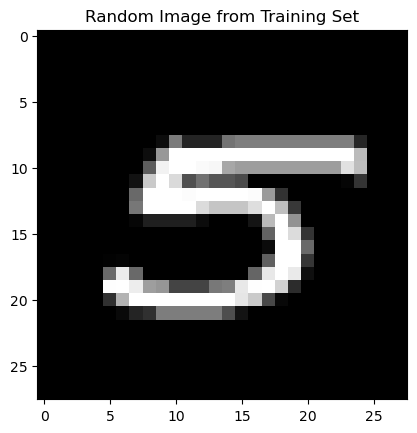

In [28]:
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import random

# Definition of the MNISTDataset and create_data_loaders functions should be above here

# Call the function and store the returned datasets and loaders
batch_size = 64  # Example batch size, adjust as needed
train_loader, val_loader, test_loader, train_dataset = create_data_loaders(batch_size)

# Now you can use train_dataset as needed:
rand_idx = random.randint(0, len(train_dataset)-1)
image, _ = train_dataset[rand_idx]  # Get a random image from the training dataset

# Convert tensor to image for displaying
transform = transforms.ToPILImage()
image_show = transform(image.squeeze(0))  # Assuming the image is a 1-channel grayscale image
plt.imshow(image_show, cmap='gray')
plt.title("Random Image from Training Set")
plt.show()



In [30]:
def visualize_feature_maps(model, image):
    # Ensure model is in eval mode
    model.eval()
    
    # Add a batch dimension (CNN expects batches)
    image = image.unsqueeze(0)
    
    # Forward pass through the model
    _ = model(image)
    
    # Visualize feature maps
    for layer_idx, feature_map in enumerate(model.feature_maps):
        layer_num = layer_idx + 1
        print(f"Feature maps for Conv Layer {layer_num}")
        num_feature_maps = feature_map.size(1)  # Number of feature maps in this layer
        
        # Create a grid of subplots
        fig, axs = plt.subplots(1, num_feature_maps, figsize=(num_feature_maps * 2, 2))
        
        for i in range(num_feature_maps):
            axs[i].imshow(feature_map[0, i].detach().numpy(), cmap='gray')
            axs[i].axis('off')
        
        #plt.show()


#visualize_feature_maps(model, image)


Feature maps for Conv Layer 1
Feature maps for Conv Layer 2


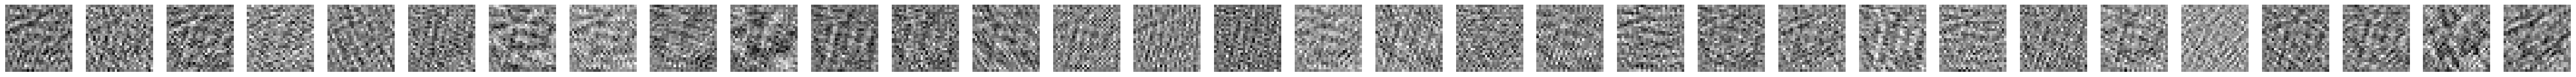

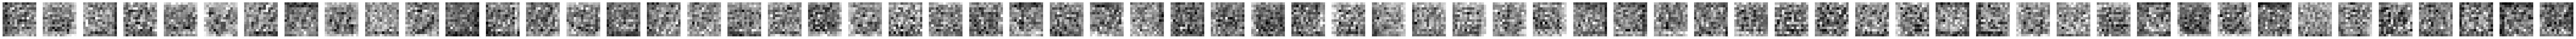

In [31]:
import torch
from torchvision import transforms

# Load or define your model
model = CNN(num_layers=2, kernel_size=5)  # Using your previously defined CNN structure

# If you have saved model weights
# model.load_state_dict(torch.load('path_to_saved_model.pth'))

# Make sure the model is on the right device (CPU in this case)
model.to('cpu')


transform = transforms.ToTensor()
# Make sure the image is a PIL image or similar for ToTensor transform, or directly use a suitable tensor
# image = PIL.Image.open('path_to_image.jpg')
# image = transform(image)  # Convert to tensor

# Randomly initialize an image tensor for demonstration (replace this with actual data)
image = torch.randn(1, 28, 28)  # Assuming MNIST 28x28 grayscale images

# Call the visualization function
visualize_feature_maps(model, image)
